In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywebrtc import CameraStream, ImageRecorder
import ipywidgets as widgets
import os
mpl.rcParams['image.cmap'] = 'gray'

In [2]:
term= """gnome-terminal -e 'sh -c "droidcam; sleep -1"'"""
os.system(term)

0

In [3]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [4]:
recoder= ImageRecorder(stream=camera)
recoder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

(480, 640, 4)


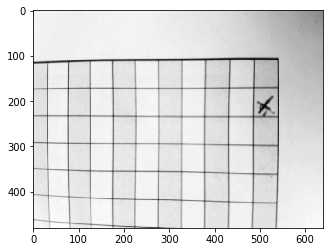

In [102]:
img=recoder.image
import PIL.Image
import io
im = np.uint8(PIL.Image.open(io.BytesIO(img.value)))
img= im[:,:,0]
print(im.shape)
plt.imshow(img)

In [117]:
 # Thresholding the image
def f(x):
    (thresh, img_bin) = cv2.threshold(img,x, 255,cv2.THRESH_BINARY|     cv2.THRESH_OTSU)
    # Invert the image
    img_bin = 255-img_bin 
    plt.axis('off')
    plt.imshow(img_bin)
interact(f,  x=widgets.IntSlider(min=10,max=100,step=1,value=10));

interactive(children=(IntSlider(value=10, description='x', min=10), Output()), _dom_classes=('widget-interact'…

In [35]:
%%time
def f(x):
    # Defining a kernel length
    global horizontal_lines_img, verticle_lines_img, kernel
    kernel_length = np.array(img).shape[1]//x

    # A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
    cv2.imwrite("verticle_lines.jpg",verticle_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    plt.subplot(1, 2, 1)  # 2 rows, 2 columns, 1st subplot = top left
    plt.imshow(verticle_lines_img);
    plt.subplot(1, 2, 2)  # 2 rows, 2 columns, 2nd subplot = top right
    plt.imshow(horizontal_lines_img);
interact(f,  x=widgets.IntSlider(min=10,max=100,step=1,value=10));


interactive(children=(IntSlider(value=10, description='x', min=10), Output()), _dom_classes=('widget-interact'…

CPU times: user 654 ms, sys: 253 ms, total: 907 ms
Wall time: 452 ms


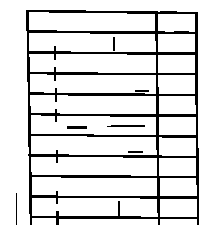

In [36]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha
# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(img_final_bin)

In [37]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Find contours for image, which will detect all the boxes
im2, contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the contours by top to bottom.
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

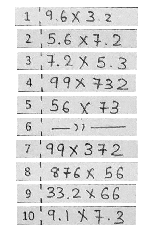

In [38]:
idx = 0
for c in contours:
    # Returns the location and width,height for every contour
    x, y, w, h = cv2.boundingRect(c)
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
    if (w > 80 and h > 20) and w > 3*h:
        idx += 1
        new_img = img[y:y+h, x:x+w]
        plt.subplot(10,1, idx)
        plt.imshow(new_img )
        plt.axis('off')
